# 手写数字分类与卷积神经网络

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 预处理数据

**torchvision：** torchvision是torch用来处理图像和视频的扩展库，提供了很多数据集、模型和转换函数，其中torchvision.datasets.MNIST提供了手写数字数据集，torchvision.models提供了很多预训练模型，torchvision.transforms提供了数据预处理函数。

为了统一数据加载和处理代码，Pytorch提供了torch.utils.data模块，其中包含Dataset和DataLoader两个类，Dataset用于封装数据集，DataLoader用于批量加载数据。通过这两个类可使数据集加载和预处理代码与模型训练代码分离，提高代码的模块化、可读性和可维护性。

pytorch内置图片数据集均在torchvision.datasets模块中，如Caltech、CelebA、CIFAR、Cityscapes、COCO、Fashion-MNIST、ImageNet、MNIST等。

ToTensor() 作用：
    1. 将输入转化为tensor
    2. 将图片格式（高， 宽通道数）转化为（通道数， 高， 宽），规范图片格式
    3. 将像素值范围从0-255缩放到0-1之间


常见图片格式：（高， 宽， 通道数）

In [2]:
# 导入torchvision库
from torchvision import datasets, transforms
# 定义一个转换函数，将图像转换为张量（Tensor）
transformation = transforms.Compose([
                                transforms.ToTensor(),  # transforms.ToTensor()会将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
                                # transforms.Normalize((0.5,), (0.5,))  # transforms.Normalize()会将图像的像素值进行标准化，即将像素值减去均值，然后除以标准差
])

# 从datasets模块中导入MNIST数据集
# 训练集
train_ds = datasets.MNIST(
                          # 数据集的存储路径
                          'dataset/',
                          # 是否为训练集
                          train=True,
                          # 数据集的转换函数
                          transform=transformation,
                          # 是否下载数据集
                          download=True  
)
# 测试集
test_ds = datasets.MNIST(
                          'dataset/',
                          train=False,
                          transform=transformation,
                          download=True  
)

**torch.utils.data.DataLoader** *DataLoader是Pytorch中用于批量加载数据的类，它可以将数据集封装为一个迭代器，每次迭代返回一个批次的数据*

    1. dataset：数据集  
    2. batch_size：批次大小  
    3. shuffle：是否打乱数据集  
    4. num_workers：加载数据的线程数  
    5. drop_last：是否丢弃最后一个批次的数据，如果最后一个批次的数据量小于batch_size，则丢弃  
    6. timeout：加载数据的超时时间  
    7. pin_memory：是否使用锁页内存，锁页内存可以提高数据加载的速度  
    8. sampler：采样器，用于指定数据集的采样方式  
    9. batch_sampler：批次采样器，用于指定数据集的批次采样方式  
    10. collate_fn：用于将多个样本合并为一个批次的数据的函数  
    11. drop_last_batch：是否丢弃最后一个批次的数据，如果最后一个批次的数据量小于batch_size，则丢弃  
    12. persistent_workers：是否使用持久化工作线程，如果为True，则每次迭代都会使用同一个工作线程，可以提高数据加载的速度  

In [3]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True) # 对dataset进行封装，将数据批量加载，batch_size为64，shuffle为True表示打乱数据集
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

## 熟悉数据集

torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
(28, 28)
tensor(2)


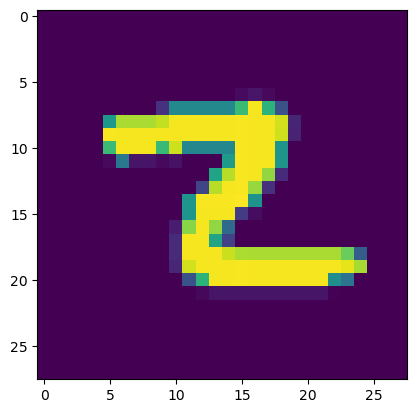

In [4]:
# iter()函数可以将一个可迭代对象转换为一个迭代器
# next()函数可以从迭代器中获取一个批次的数据
imgs, labels = next(iter(train_dl))
# 在pytorch里面图片的表示形式：【batch， channel， hight， width】
# transforms.ToTensor()将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
print(imgs.shape) # [batch, channel, hight, width]
img = imgs[0] # 切片取出一张图片
print(img.shape) # [channel, hight, width]
img = img.numpy() # 将张量转换为numpy数组(ndarray)
img = np.squeeze(img) # 将张量中的维度为1的维度去掉
print(img.shape) # [hight, width]
print(labels[0]) # 打印出图片对应的标签
plt.imshow(img)  # 显示图片

tensor([2, 3, 7, 4, 7, 5, 1, 6, 5, 1])


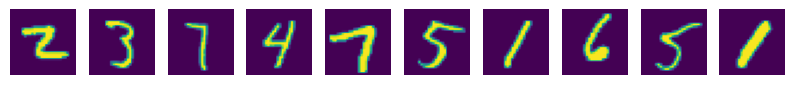

In [5]:
print(labels[:10]) # 打印出前10张图片对应的标签
# 图片显示函数
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)
plt.figure(figsize=(10, 1)) # 创建一个figure画布对象，设置大小为10*1
# 遍历imgs中的前10张图片
for i, img in enumerate(imgs[:10]):
    plt.subplot(1, 10, i+1) # 绘制子图，设置子图的行数为1，列数为10，第i+1个子图
    plt.axis('off') # 关闭坐标轴
    imshow(img)

## 创建模型

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # 卷积层，输入通道数为1，输出通道数为6，卷积核大小为5，步长为1，填充为0
        self.pool = nn.MaxPool2d(kernel_size=(2, 2)) # 池化层，池化核大小为2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # 卷积层，输入通道数为6，输出通道数为16，卷积核大小为5，步长为1，填充为0
        self.liner_1 = nn.Linear(16 * 4 * 4, 256)    # 输入层到隐藏层，全连接层，超参数选择为256
        self.liner_2 = nn.Linear(256, 10)       # 隐藏层到输出层，分类数为10
    def forward(self, input):
        x = F.relu(self.conv1(input))           # 第一层卷积，激活函数为ReLU
        x = self.pool(x)                        # 池化层
        x = F.relu(self.conv2(x))               # 第二层卷积，激活函数为ReLU
        x = self.pool(x)                        # 池化层
        # print(x.shape) # [batch, channel, hight, width]   [64, 16, 4, 4]
        x = x.view(x.size(0), -1)           # 将输入的图片展平，将channel维度去掉，将hight和width维度合并为一个维度 16 * 4 * 4
        x = F.relu(self.liner_1(x))             # 第一层，激活函数为ReLU
        logits = self.liner_2(x)                # 输出层，不使用激活函数，未激活的输出通常被称为logits
        return logits

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model = Model().to(device) # 将模型移动到GPU上实例化模型

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
# opt = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.001
opt = torch.optim.SGD(model.parameters(), lr=0.001) # 优化器，SGD优化器，学习率为0.001

## 编写训练循环

In [8]:
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

In [9]:
# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

## 进行训练

In [10]:
# 通用训练函数，输入模型、训练数据、测试数据，返回loss和acc变化
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

In [11]:
epochs = 20
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 2.2880, Train Acc: 13.77%, Test Loss: 2.2698, Test Acc: 18.90%
Epoch: 1, Train Loss: 2.2431, Train Acc: 28.95%, Test Loss: 2.2002, Test Acc: 47.98%
Epoch: 2, Train Loss: 2.0968, Train Acc: 59.28%, Test Loss: 1.9013, Test Acc: 69.16%
Epoch: 3, Train Loss: 1.4478, Train Acc: 75.06%, Test Loss: 0.9324, Test Acc: 81.26%
Epoch: 4, Train Loss: 0.7194, Train Acc: 82.98%, Test Loss: 0.5458, Test Acc: 86.16%
Epoch: 5, Train Loss: 0.5041, Train Acc: 86.26%, Test Loss: 0.4292, Test Acc: 88.63%
Epoch: 6, Train Loss: 0.4174, Train Acc: 88.18%, Test Loss: 0.3647, Test Acc: 89.64%
Epoch: 7, Train Loss: 0.3662, Train Acc: 89.50%, Test Loss: 0.3249, Test Acc: 90.61%
Epoch: 8, Train Loss: 0.3300, Train Acc: 90.44%, Test Loss: 0.2968, Test Acc: 91.40%
Epoch: 9, Train Loss: 0.3029, Train Acc: 91.23%, Test Loss: 0.2694, Test Acc: 92.14%
Epoch: 10, Train Loss: 0.2812, Train Acc: 91.81%, Test Loss: 0.2494, Test Acc: 92.54%
Epoch: 11, Train Loss: 0.2629, Train Acc: 92.32%, Test Loss: 0.2

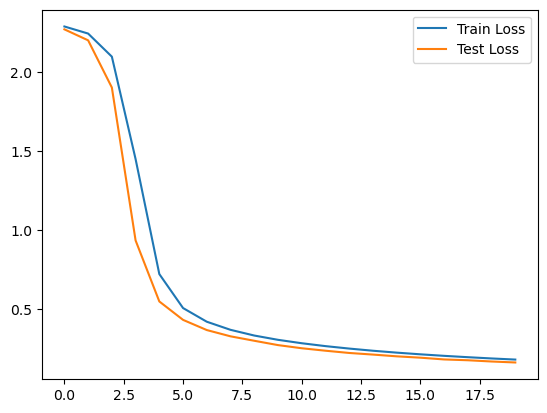

In [12]:
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), test_loss, label='Test Loss')
plt.legend()

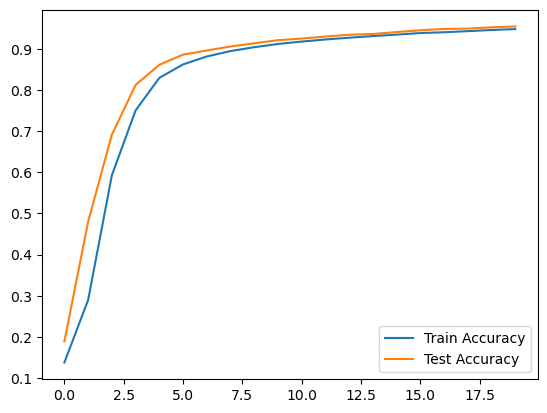

In [13]:
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), test_acc, label='Test Accuracy')
plt.legend()

## 通用训练模板

In [14]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model = Model().to(device) # 将模型移动到GPU上实例化模型

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.SGD(model.parameters(), lr=0.001) # 优化器，SGD优化器，学习率为0.001
epochs = 20

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)


Epoch: 0, Train Loss: 2.2957, Train Acc: 13.04%, Test Loss: 2.2880, Test Acc: 15.03%
Epoch: 1, Train Loss: 2.2771, Train Acc: 20.29%, Test Loss: 2.2629, Test Acc: 25.77%
Epoch: 2, Train Loss: 2.2358, Train Acc: 40.83%, Test Loss: 2.1922, Test Acc: 53.11%
Epoch: 3, Train Loss: 2.0733, Train Acc: 62.81%, Test Loss: 1.8537, Test Acc: 70.47%
Epoch: 4, Train Loss: 1.3901, Train Acc: 73.18%, Test Loss: 0.9145, Test Acc: 79.56%
Epoch: 5, Train Loss: 0.7347, Train Acc: 81.26%, Test Loss: 0.5803, Test Acc: 83.87%
Epoch: 6, Train Loss: 0.5453, Train Acc: 84.60%, Test Loss: 0.4765, Test Acc: 86.44%
Epoch: 7, Train Loss: 0.4684, Train Acc: 86.30%, Test Loss: 0.4181, Test Acc: 87.46%
Epoch: 8, Train Loss: 0.4218, Train Acc: 87.48%, Test Loss: 0.3817, Test Acc: 88.37%
Epoch: 9, Train Loss: 0.3878, Train Acc: 88.36%, Test Loss: 0.3511, Test Acc: 89.17%
Epoch: 10, Train Loss: 0.3611, Train Acc: 89.09%, Test Loss: 0.3279, Test Acc: 89.89%
Epoch: 11, Train Loss: 0.3393, Train Acc: 89.71%, Test Loss: 0.3